In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
import cv2

from Faraday.two_dim.module.lib.layers import *
import Faraday.two_dim.module.lib.functions as func
from Faraday.two_dim.module.lib import optical_chart

plt.rcParams["font.size"]=18
plt.rcParams["image.cmap"] = "viridis"
plt.rcParams["axes.grid"] = False

$$
\begin{aligned}
\dfrac{\partial \mathcal{L}}{\partial \phi^{n-1}(x,y)} &=
\dfrac{\partial \mathcal{L}}{\partial I^n_{out}(x,y)}
\dfrac{\partial I^n_{out}(x,y)}{\partial E^n_{in}(x,y)}
\dfrac{\partial E^n_{in}(x,y)}{\partial E^{n-1}_{out}(x,y)}
\dfrac{\partial E^{n-1}_{out}(x,y)}{\partial \phi^{n-1}(x,y)} \\

\dfrac{\partial \mathcal{L}}{\partial I^n_{out}(x,y)} &= 2(I^n_{out}(x,y)-I^{target}(x,y)) \\

\dfrac{\partial I^n_{out}(x,y)}{\partial E^n_{in}(x,y)} &= \dfrac{\partial E^n_{in}(x,y)\bar{E}^n_{in}(x,y)}{\partial E^n_{in}(x,y)}=2\bar{E}^n_{in}(x,y) \\

\dfrac{\partial E^n_{in}(x,y)}{\partial E^{n-1}_{out}(x,y)} &=
\dfrac{\partial}{\partial E^{n-1}_{out}(x,y)} \iint
\left \{
  \left(
    \iint E^{n-1}_{out}(x,y)\exp(-i2\pi(ux+vy))dxdy
  \right)
  H(x,y,z^n-z^{n-1}) \exp(i2\pi(ux+vy))
  \right \}
dudv \\

&= \iint \left \{ \left( \iint \exp(-i2\pi(ux+vy))dxdy \right)H(x,y,z^n-z^{n-1}) \exp(i2\pi(ux+vy))\right \}dudv \\

&= \iint \delta(u)\delta(v) H(x,y,z^n-z^{n-1}) \exp(i2\pi(ux+vy))dudv \\

&=  \mathcal{F}[\delta(u)\delta(v)H(x,y,z^n-z^{n-1})] \\

\dfrac{\partial E^{n-1}_{out}}{\partial \phi^{n-1}} &= Re\left \{iE^{n-1}_{in} \exp \left ( i\phi^{n-1} \right )\right \}
\end{aligned}
$$

共通変数

In [2]:
shape = (100, 100)

wavelength = 633e-9
d = 1.0e-6
z = 0.4e-3
u = np.fft.fftfreq(shape[1], d)
v = np.fft.fftfreq(shape[0], d)
UU, VV = np.meshgrid(u, v)
du = 1.0 / (shape[1] * d)
dv = 1.0 / (shape[0] * d)
u_lim = 1.0 / (wavelength * np.sqrt((2.0 * du * z) ** 2 + 1.0))
v_lim = 1.0 / (wavelength * np.sqrt((2.0 * dv * z) ** 2 + 1.0))
u_filter = np.where(np.abs(UU / (2 * u_lim)) < 1 / 2, 1, 0)
v_filter = np.where(np.abs(VV / (2 * v_lim)) < 1 / 2, 1, 0)
w = np.where((UU**2 + VV**2) <= 1 / wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
H = tf.constant(np.exp(1.0j * 2.0 * np.pi * w * z) * u_filter * v_filter, dtype=tf.complex128)

u_lim = 1.0 / (wavelength * np.sqrt((2.0 * du * 2*z) ** 2 + 1.0))
v_lim = 1.0 / (wavelength * np.sqrt((2.0 * dv * 2*z) ** 2 + 1.0))
u_filter = np.where(np.abs(UU / (2 * u_lim)) < 1 / 2, 1, 0)
v_filter = np.where(np.abs(VV / (2 * v_lim)) < 1 / 2, 1, 0)
w = np.where((UU**2 + VV**2) <= 1 / wavelength**2, np.sqrt(1/wavelength**2 - UU**2 - VV**2), 0)
H2 = tf.constant(np.exp(1.0j * 2.0 * np.pi * w * 2*z) * u_filter * v_filter, dtype=tf.complex128)

y = np.zeros(shape)
y[40:60,40:60] = 1.0
y = tf.constant(y)
data = tf.constant(np.loadtxt("../Faraday/two_dim/data/phase/100px/train_5.csv"), dtype=tf.complex128)

# phi = tf.Variable(np.random.random(shape) * np.pi)

m1 = tf.Variable(np.random.random(shape)*2.0)
m2 = tf.Variable(np.random.random(shape)*2.0)
m3 = tf.Variable(np.random.random(shape)*2.0)

theta1_b = np.pi
eta1_b = 0.0

iter = 500
alpha = 0.9
beta1 = 0.1
beta2 = 0.1
history = []
v1 = 0.0
s1 = 0.0

Metal device set to: Apple M1


2022-09-16 13:19:56.260269: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-09-16 13:19:56.260557: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
def propagation(src):
    pad_image = tf.pad(src, [[50, 50],[50,50]])
    u = np.fft.fftfreq(pad_image.shape[1], d=d)
    v = np.fft.fftfreq(pad_image.shape[0], d=d)

    du = 1 / (pad_image.shape[1] * d)
    dv = 1 / (pad_image.shape[0] * d)
    u_limit = 1 / (np.sqrt((2 * du * z) ** 2 + 1)) / wavelength
    v_limit = 1 / (np.sqrt((2 * dv * z) ** 2 + 1)) / wavelength
    UU, VV = np.meshgrid(u, v)

    u_filter = np.where(np.abs(UU) <= u_limit, 1, 0)
    v_filter = np.where(np.abs(VV) <= v_limit, 1, 0)

    w = np.where(UU ** 2 + VV ** 2 <= 1 / wavelength ** 2, tf.sqrt(1 / wavelength ** 2 - UU ** 2 - VV ** 2), 0).astype('float64')
    h = np.exp(1.0j * 2 * np.pi * w * z)
    h = h * u_filter * v_filter
    image = tf.signal.ifft2d(tf.signal.fft2d(pad_image)* tf.constant(h))
    return image[50:150, 50:150]

# GradientTapeでの実装
## 1層

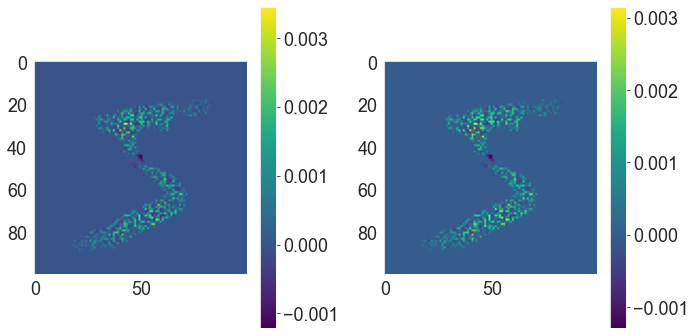

In [6]:
with tf.GradientTape() as tape:
    tape.watch(m1)
    theta1 = theta1_b * tf.sin(m1)
    eta1 = eta1_b * tf.sin(m1)
    s1_rcp_x = tf.complex((1.0+eta1)/(1.0+eta1_b), 0.0*m1) * data * tf.complex(tf.cos(-theta1), tf.sin(-theta1))
    s1_lcp_x = tf.complex((1.0-eta1)/(1.0+eta1_b), 0.0*m1) * data * tf.complex(tf.cos(theta1), tf.sin(theta1))
    g2_rcp_x = propagation(s1_rcp_x)
    g2_lcp_x = propagation(s1_lcp_x)

    g2_x = g2_rcp_x + g2_lcp_x
    g2_y = 1.0j * g2_rcp_x - 1.0j * g2_lcp_x

    o = g2_x*tf.math.conj(g2_x) + g2_y*tf.math.conj(g2_y)

    loss = tf.reduce_mean((y-tf.math.real(o))**2)

tape_grad = tape.gradient(loss, m1)

my_grad1 = tf.signal.ifft2d(
    tf.signal.fft2d(
        4.0*(o-tf.complex(y, 0.0*y))*tf.math.conj(g2_x)) * H
)

my_grad2 = tf.signal.ifft2d(
    tf.signal.fft2d(
        4.0*(o-tf.complex(y, 0.0*y))*tf.math.conj(g2_y)) * H
)

#my_grad2 = tf.cast(tf.complex(1.0, 1.0), tf.complex128) * (-1.0j * tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_rcp_x +  tf.complex((eta1_b * tf.cos(m1))/(1.0+eta1), 0.0*m1) + s1_rcp_x) + tf.cast(tf.complex(1.0, -1.0), tf.complex128)*(1.0j * tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_lcp_x - tf.complex((eta1_b * tf.cos(m1))/(1.0-eta1), 0.0*m1) + s1_rcp_x)

my_grad3 = -1.0j * tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_rcp_x + tf.complex((eta1_b * tf.cos(m1))/(1.0+eta1), 0.0*m1) * s1_rcp_x + 1.0j * tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_lcp_x - tf.complex((eta1_b * tf.cos(m1))/(1.0-eta1), 0.0*m1) * s1_lcp_x
my_grad4 = tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_rcp_x + 1.0j * tf.complex((eta1_b * tf.cos(m1))/(1.0+eta1), 0.0*m1) * s1_rcp_x + tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_lcp_x + 1.0j * tf.complex((eta1_b * tf.cos(m1))/(1.0-eta1), 0.0*m1) * s1_lcp_x
my_grad = my_grad1 * my_grad3 + my_grad2 * my_grad4
my_grad = my_grad/(100*100)


fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy().real)
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()

## 2層

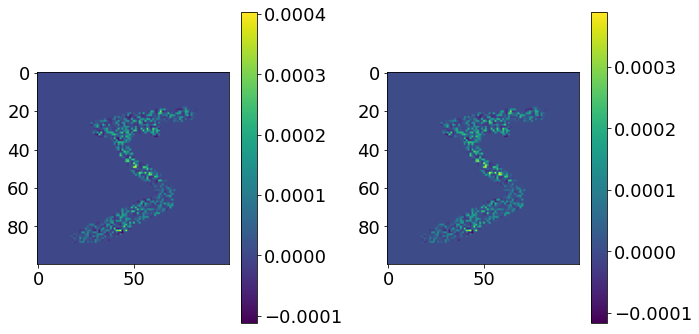

In [165]:
with tf.GradientTape() as tape:
    tape.watch(m1)
    theta1 = theta1_b * tf.sin(m1)
    eta1 = eta1_b * tf.sin(m1)
    s1_rcp_x = tf.complex((1.0+eta1)/(1.0+eta1_b), 0.0*m1) * data * tf.complex(tf.cos(-theta1), tf.sin(-theta1))
    s1_lcp_x = tf.complex((1.0-eta1)/(1.0+eta1_b), 0.0*m1) * data * tf.complex(tf.cos(theta1), tf.sin(theta1))
    g2_rcp_x = propagation(s1_rcp_x)
    g2_lcp_x = propagation(s1_lcp_x)

    theta2 = theta1_b *tf.sin(m2)
    eta2 = eta1_b *tf.sin(m2)
    s2_rcp_x = tf.complex((1.0+eta2)/(1.0+eta1_b), 0.0*m2) * g2_rcp_x * tf.complex(tf.cos(-theta2), tf.sin(-theta2))
    s2_lcp_x = tf.complex((1.0-eta2)/(1.0+eta1_b), 0.0*m2) * g2_lcp_x * tf.complex(tf.cos(theta2), tf.sin(theta2))
    g3_rcp_x = propagation(s2_rcp_x)
    g3_lcp_x = propagation(s2_lcp_x)

    g3_x = g3_rcp_x + g3_lcp_x
    g3_y = 1.0j * g3_rcp_x - 1.0j * g3_lcp_x

    o = g3_x*tf.math.conj(g3_x) + g3_y*tf.math.conj(g3_y)

    loss = tf.reduce_mean((y-tf.math.real(o))**2)

tape_grad = tape.gradient(loss, m1)

my_grad1 = tf.signal.ifft2d(
    tf.signal.fft2d(
        4.0*(o-tf.complex(y, 0.0*y))*tf.math.conj(g3_x)) * H
)

my_grad2 = tf.signal.ifft2d(
    tf.signal.fft2d(
        4.0*(o-tf.complex(y, 0.0*y))*tf.math.conj(g3_y)) * H
)

my_grad_x1 = tf.complex(tf.cos(-theta2), tf.sin(-theta2))*my_grad1
my_grad_x2 = tf.complex(tf.cos(theta2), tf.sin(theta2)) * my_grad1
my_grad_x1 = propagation(my_grad_x1)
my_grad_x2 = propagation(my_grad_x2)
my_grad_x1 =  -1.0j * tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_rcp_x * my_grad_x1
my_grad_x2 = 1.0j * tf.complex(theta1_b * tf.cos(m1), 0.0*m1)* s1_lcp_x * my_grad_x2
my_grad_x = my_grad_x1 + my_grad_x2

my_grad_y1 = 1.0j*tf.complex(tf.cos(-theta2), tf.sin(-theta2)) * my_grad2
my_grad_y2 = -1.0j*tf.complex(tf.cos(theta2), tf.sin(theta2)) * my_grad2
my_grad_y1 = propagation(my_grad_y1)
my_grad_y2 = propagation(my_grad_y2)
my_grad_y1 = -1.0j * tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_rcp_x * my_grad_y1
my_grad_y2 = 1.0j * tf.complex(theta1_b * tf.cos(m1), 0.0*m1) * s1_lcp_x * my_grad_y2
my_grad_y = my_grad_y1 + my_grad_y2

my_grad = my_grad_x + my_grad_y
my_grad = my_grad/(100*100)


fig, axes = plt.subplots(1, 2, figsize=[10,5])
im1 = axes[0].imshow(tape_grad.numpy().real)
cbar1 = fig.colorbar(im1, ax=axes[0])
im2 = axes[1].imshow(my_grad.numpy().real)
cbar2 = fig.colorbar(im2, ax=axes[1])
fig.tight_layout()